In [2]:
def fetch_ohlcv(symbol, exchange_id, timeframe, since=None, limit=1000, max_bars=None):
    exchange = getattr(ccxt, exchange_id)()
    exchange.load_markets()

    all_bars = []
    fetch_since = since if since else exchange.milliseconds() - (max_bars * 60 * 60 * 1000)  # Adjusted for 1-hour data

    while len(all_bars) < max_bars:
        try:
            new_bars = exchange.fetch_ohlcv(symbol, timeframe, since=fetch_since, limit=limit)

            if not new_bars:
                print("No new bars returned. Stopping...")
                break  # Stop if no new data is returned

            all_bars.extend(new_bars)  # Append new data
            print(f"Fetched {len(new_bars)} bars, Total: {len(all_bars)}")

            fetch_since = new_bars[-1][0] + 1  # Move `since` forward

            if len(new_bars) < limit:
                print("Last batch returned less than the limit. Likely at the end of data.")
                break  # Stop if no more data is available
            
            time.sleep(exchange.rateLimit / 1000)  # Avoid API rate limits
            
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # **Updated Technical Indicators for 1-Hour Data**
    df["SMA_20"] = ta.trend.sma_indicator(df["close"], window=20)  # 20-period SMA
    df["SMA_50"] = ta.trend.sma_indicator(df["close"], window=50)  # 50-period SMA
    df["EMA_20"] = ta.trend.ema_indicator(df["close"], window=20)  # 20-period EMA
    df["RSI_14"] = ta.momentum.rsi(df["close"], window=14)  # RSI (Relative Strength Index)
    df["MACD"] = ta.trend.macd(df["close"])  # MACD Line
    df["MACD_Signal"] = ta.trend.macd_signal(df["close"])  # MACD Signal Line
    df["ATR_14"] = ta.volatility.average_true_range(df["high"], df["low"], df["close"], window=14)  # ATR
    
    df.dropna(inplace=True)  # Drop NaN values from indicator calculations
    
    print(f"Final data count: {len(df)} bars")
    return df

Fetched 1000 bars, Total: 1000
Error fetching data: name 'time' is not defined
Final data count: 951 bars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━

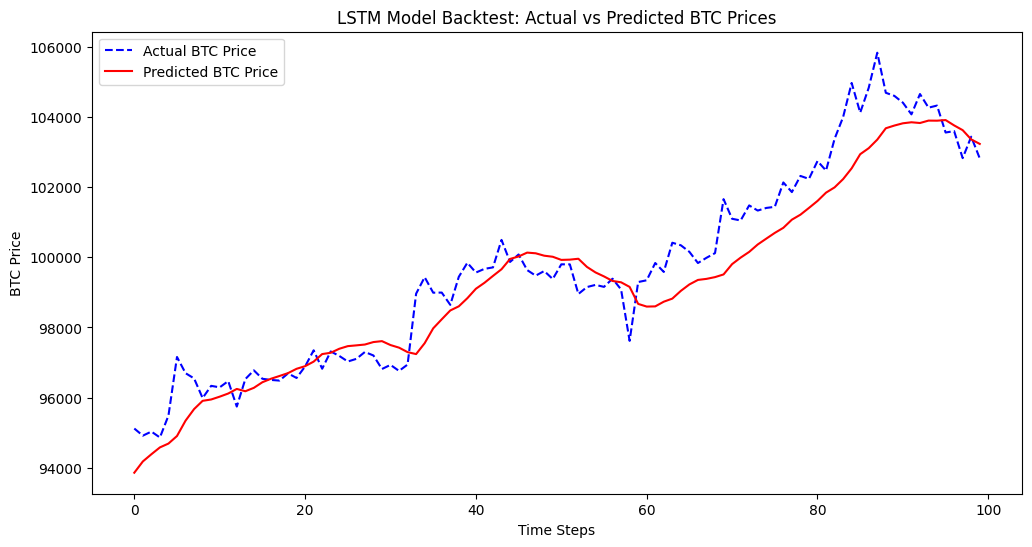

In [5]:
import numpy as np
import pandas as pd
import joblib
import ccxt
import ta
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the trained LSTM model
model = load_model("btcpricetest_model2.keras", safe_mode=False)

# Load scalers
scaler_X = joblib.load("scaler_X.pkl")  # Feature scaler
scaler_y = joblib.load("scaler_y.pkl")  # Target scaler

# Define sequence length (same as during training)
seq_length = 20  # Adjust based on your training settings

# Feature columns used in training
feature_columns = ['open', 'high', 'low', 'volume', "SMA_20", "SMA_50", "EMA_20", "RSI_14", "MACD", "MACD_Signal", "ATR_14"]

# **Backtesting Function**
def backtest_lstm(num_predictions=100):
    """
    Runs backtesting for the LSTM model by making sequential predictions on historical BTC data.
    """
    required_bars = seq_length + num_predictions  # Ensure we have enough historical data

    # **Fetch historical BTC data**
    df = fetch_ohlcv("BTC/USDT", "binance", "1h", max_bars=1500)

    # **Error Handling: Ensure Enough Data is Available**
    if df is None or len(df) < required_bars:
        print(f"⚠️ Not enough data for backtesting. Required: {required_bars}, Found: {len(df)}")
        return None

    df_feature = df[feature_columns]
    df_actual = df["close"].iloc[seq_length:seq_length + num_predictions].reset_index(drop=True)  # Fix misalignment

    predictions = []

    # **Loop through historical data and predict each timestep**
    for i in range(num_predictions):
        # Extract the last `seq_length` rows
        input_data = df_feature.iloc[i : i + seq_length]

        # Scale the input features
        df_scaled = scaler_X.transform(input_data)

        # Reshape for LSTM input (1 sample, `seq_length` timesteps, feature count)
        input_seq = df_scaled.reshape(1, seq_length, len(feature_columns))

        # Make a prediction
        pred_scaled = model.predict(input_seq)

        # Convert back to original BTC price scale
        pred_actual = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

        predictions.append(pred_actual)

    # **Convert Predictions to Pandas Series for Comparison**
    df_predictions = pd.Series(predictions, index=df_actual.index)

    # **Calculate Backtest Metrics**
    mse = mean_squared_error(df_actual, df_predictions)
    mae = mean_absolute_error(df_actual, df_predictions)
    mape = np.mean(np.abs((df_actual - df_predictions) / df_actual)) * 100
    r2 = r2_score(df_actual, df_predictions)

    print(f"\n📊 **Backtest Results:**")
    print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"🔹 R-Squared (R²): {r2 * 100:.2f}%")

    # **Plot Actual vs Predicted Prices**
    plt.figure(figsize=(12, 6))
    plt.plot(df_actual.index, df_actual, label="Actual BTC Price", color="blue", linestyle='dashed')
    plt.plot(df_predictions.index, df_predictions, label="Predicted BTC Price", color="red")
    plt.xlabel("Time Steps")
    plt.ylabel("BTC Price")
    plt.title("LSTM Model Backtest: Actual vs Predicted BTC Prices")
    plt.legend()
    plt.show()

# **Run Backtest**
backtest_lstm(num_predictions=100)  # Predict the next 100 hours based on past data
